# ADCP Example

The following example shows a typical workflow for analyzing ADCP data using DOLfYN's tools. [DOLfYN]

A typical ADCP data workflow is broken down into
  1. Review the raw data
      - Check timestamps
      - Calculate/check that the depth bin locations are correct
      - Look at velocity, beam amplitude and/or beam correlation data quality
  2. Remove data located above the water surface or below the seafloor
  3. Check for spurious datapoints and remove if necessary
  4. If not already done within the instrument, average the data into bins of a set time length (normally 5 to 10 min)
  5. Conduct further analysis as required

Start by importing the necessary DOLfYN tools through MHKiT:

In [1]:
# Import core DOLfYN functions
import dolfyn as dlfn
# Import ADCP-specific API tools
import dolfyn.adp.api as api

## Read Raw Instrument Data

The core benefit of DOLfYN is that it can read in raw data directly after transferring it off of the ADCP. The instruments that DOLfYN supports are listed in the documentation. The ADCP used here is a Nortek Signature 1000, with the file extension '.ad2cp'. This specific dataset contains several hours worth of velocity data collected at 1 Hz from the ADCP mounted on a bottom lander in a tidal inlet. Depending on how large the file is, this could take a few minutes.

ADCPs record three main types of data: the measured velocity, amplitude, and correlation. The latter two are measures of acoustic backscatter and the return signal quality, respectively. The dataset will also contain orientation data that DOLfYN uses to rotate the dataset through the proper coordinate systems.

In [2]:
dat = dlfn.read_example('Sig1000_tidal.ad2cp') # use `dlfn.read([path to file + filename])` for your data
dat

Indexing... Done.
Reading file c:\users\mcve343\dolfyn\dolfyn\example_data\Sig1000_tidal.ad2cp ...


<xarray.Dataset>
Dimensions:              (time: 73151, time_b5: 73151, dirIMU: 3, range_b5: 28, beam: 4, range: 28, dir: 4, inst: 3, earth: 3, q: 4, x*: 4)
Coordinates:
  * time                 (time) float64 1.597e+09 1.597e+09 ... 1.597e+09
  * time_b5              (time_b5) float64 1.597e+09 1.597e+09 ... 1.597e+09
  * dirIMU               (dirIMU) <U1 'E' 'N' 'U'
  * range_b5             (range_b5) float64 0.6 1.1 1.6 2.1 ... 13.1 13.6 14.1
  * beam                 (beam) int32 1 2 3 4
  * range                (range) float64 0.6 1.1 1.6 2.1 ... 12.6 13.1 13.6 14.1
  * dir                  (dir) <U2 'E' 'N' 'U1' 'U2'
  * inst                 (inst) <U1 'X' 'Y' 'Z'
  * earth                (earth) <U1 'E' 'N' 'U'
  * q                    (q) <U1 'w' 'x' 'y' 'z'
  * x*                   (x*) int32 1 2 3 4
Data variables: (12/23)
    c_sound              (time) float32 1.496e+03 1.496e+03 ... 1.497e+03
    temp                 (time) float32 12.79 12.79 12.79 ... 13.01 13.0 13.0
    pressure             (time) float32 9.425 9.432 9.428 ... 8.724 8.727 8.721
    mag                  (dirIMU, time) float32 71.5 71.8 71.4 ... -197.1 -197.4
    accel                (dirIMU, time) float32 0.00958 0.02874 ... 9.705 9.705
    vel                  (dir, range, time) float32 -0.007 0.002 ... -0.037
    ...                   ...
    angrt_b5             (dirIMU, time_b5) float32 -0.001953 ... -0.00293
    quaternion_b5        (q, time_b5) float32 0.6272 0.6272 ... 0.7791 0.7791
    heading              (time) float32 -12.12 -12.12 -12.15 ... -12.67 -12.67
    pitch                (time) float32 0.23 0.21 0.22 ... -0.07 -0.07 -0.07
    roll                 (time) float32 -7.665 -7.67 -7.68 ... -7.53 -7.52 -7.53
    beam2inst_orientmat  (beam, x*) float32 1.183 0.0 -1.183 ... 0.0 0.5518
Attributes: (12/27)
    filehead_config:    {'CLOCKSTR': {'TIME': '"2020-08-13 13:56:21"'}, 'ID':...
    inst_model:         Signature1000
    inst_make:          Nortek
    inst_type:          ADCP
    rotate_vars:        ['vel', 'accel', 'accel_b5', 'angrt', 'angrt_b5', 'ma...
    burst_config:       {'press_valid': True, 'temp_valid': True, 'compass_va...
    ...                 ...
    blank_dist_b5:      0.1
    coord_sys:          earth
    orientation:        AHRS
    orient_status:      AHRS-3D
    has_imu:            1
    fs:                 1

## First Steps and QC'ing Data

### 1.) Set deployment height

Because this is a Nortek instrument, Nortek deployment software doesn't take into account where in the water column the ADCP actually is. TRDI's deployment software asks the user to enter this height, which, if needed, can be adjusted after-the-fact here as well. Before going any farther, let's adjust the depth bin locations for that:

In [3]:
# Correct the range so that '0' corresponds to the seafloor
# The ADCP transducers were measured to be 0.6 m from the feet of the tripod it was mounted on.
dat = api.clean.set_deploy_altitude(dat, 0.6)
dat.range

<xarray.DataArray 'range' (range: 28)>
array([ 1.2,  1.7,  2.2,  2.7,  3.2,  3.7,  4.2,  4.7,  5.2,  5.7,  6.2,  6.7,
        7.2,  7.7,  8.2,  8.7,  9.2,  9.7, 10.2, 10.7, 11.2, 11.7, 12.2, 12.7,
       13.2, 13.7, 14.2, 14.7])
Coordinates:
  * range    (range) float64 1.2 1.7 2.2 2.7 3.2 ... 12.7 13.2 13.7 14.2 14.7
Attributes:
    units:    m

So, the center of bin 1 is located at 1.2 m.

### 2.) Remove data beyond surface level

To reduce the amount of data the code must run through, we can remove all data at and above the water surface. Because the instrument was looking up, we can use the pressure sensor data. This does require that the pressure sensor was 'zeroed' prior to deployment. If the instrument is down-facing, there is another function for bottom-detection.

In [4]:
# Most instruments record pressure data, but not all record the water salinity.
# Water depth is stored in the variable `depth`
dat = api.clean.surface_from_P(dat, salinity=31)

# Now let's remove velocity, correlation, and amplitude data in depth bins above the physical water surface, 
# as well as depth bins corrupted by surface interference
dat = api.clean.nan_beyond_surface(dat)

### 3.) Correlation filter

Once the extra bins above the surface have been cleared away, ADCP data is typically filtered by correlation clear out spurious velocity datapoints (caused by bubbles, kelp, fish, etc moving through one or multiple beams). 

We can take a quick look at the data to see about where this value should be:

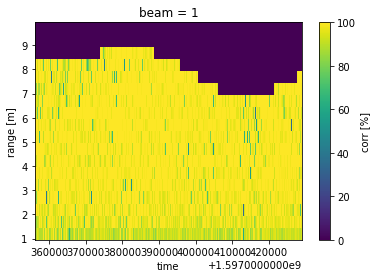

In [5]:
%matplotlib inline
dat.corr.sel(beam=1, range=slice(0,10)).plot() # quick xarray built-in plotting

It's a good idea to check the other beams as well. Much of this data is high quality, and to not lose data will low correlation caused by natural variation, we'll set the correlation filter to drop data below 50%.

Note that this value is dependent on the deployment environment and instrument, and it isn't uncommon to use a value as low as 30%, or ~70 counts.

In [6]:
# Set velocity values corresponding to correlations below 50% to NaN
dat = api.clean.correlation_filter(dat, thresh=50)

## Review the Data

Now that the data has been cleaned, the next step is to rotate the velocity data into true East, North, Up coordinates. These functions are available through MHKiT:

In [7]:
# First, set the magnetic declination to that of where the data was collected
# If in the 'earth' coordinate system, this function will automatically adjust for that
dat = dlfn.set_declination(dat, 15.8) # 15.8 deg East

# If the dataset wasn't already read in in 'earth' (ENU), coordinates, rotate it now.
dat = dlfn.rotate2(dat, 'earth')

Data is already in the earth coordinate system


Because this deployment was set up in 'burst mode' (as opposed to an 'averaging mode') the next standard step in this analysis is to average the velocity data into time bins. If an instrument was set up to record velocity data with a specific profiling and averaging interval (e.g. take 5 minutes of data every 30 minutes), this step was completed within the ADCP during deployment and can be skipped.

In [8]:
# To average the data into time bins (aka ensembles), start by initiating `VelBinner`
# n_bin is the number of data points in each ensemble, in this case 300 seconds worth of data
# fs is the sampling frequency, which is 1 Hz for this deployment
avg_tool = api.VelBinner(n_bin=dat.fs*300, fs=dat.fs)

# Average the data into ensembles
dat_avg = avg_tool.do_avg(dat)

Two more variables that can be of interest is the horizontal velocity magnitude and its direction. There are included as 'shortcuts' to the dataset, and are accessed through the keyword 'Veldata'. The full list of 'shorcut variables are listed in the DOLfYN API, but note all of them might not be available to particular instruments or data.

In [9]:
# Add horizontal velocity magnitude and direction to the dataset:
dat_avg['U_mag'] = dat_avg.Veldata.U_mag

# Because of the way ADCP coordinate systems are set up, while in ENU, velocity direction is in 'degrees CCW from East' (aka "Cartesian angle")
U_dir_East = dat_avg.Veldata.U_dir
# DOLfYN has a function to convert from 'degrees CCW from East' to 'degrees CW from North'
dat_avg['U_dir'] = dlfn.tools.misc.convert_degrees(U_dir_East)

Plotting can be accomplished through the user's preferred package. Matplotlib is shown here for simplicity:

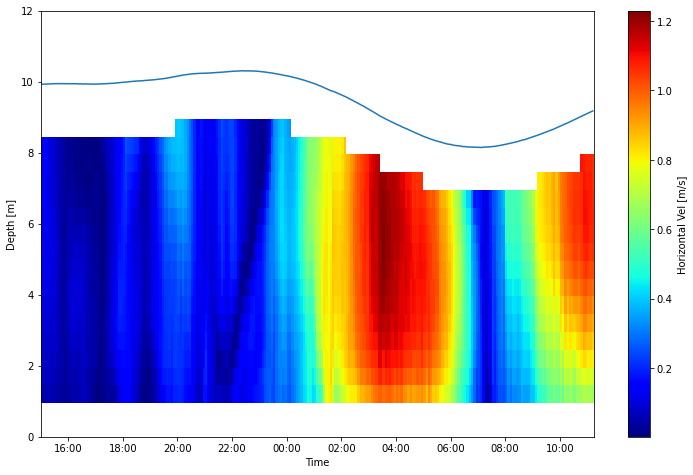

In [10]:
%matplotlib inline 
from matplotlib import pyplot as plt
import matplotlib.dates as dt

t = dlfn.time.epoch2date(dat_avg.time)

ax = plt.figure(figsize=(12,8)).add_axes([.14, .14, .8, .74])
# Plot the horizontal velocity magnitude
plt.pcolormesh(t, dat_avg.range, dat_avg.Veldata.U_mag, cmap='jet', shading='nearest')
# Plot the water surface
ax.plot(t, dat_avg.depth)

# set up time on x-axis
ax.set_xlabel('Time')
ax.xaxis.set_major_formatter(dt.DateFormatter('%H:%M'))

ax.set_ylabel('Depth [m]')
ax.set_ylim([0, 12]);
plt.colorbar(label='Horizontal Vel [m/s]');

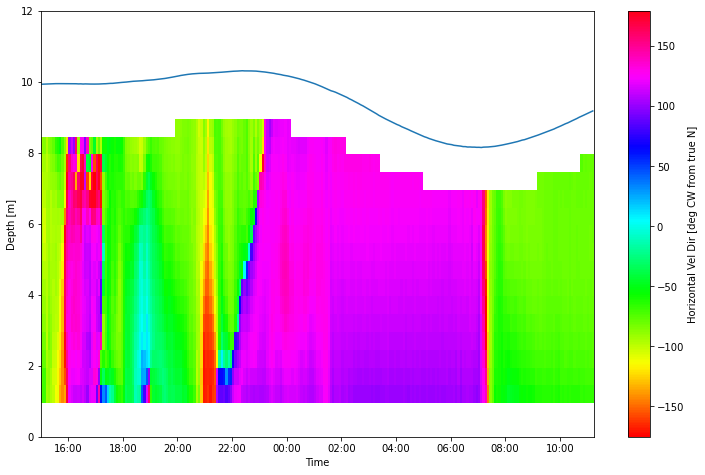

In [11]:
# Plot horizontal velocity direction
ax = plt.figure(figsize=(12,8)).add_axes([.14, .14, .8, .74])
plt.pcolormesh(t, dat_avg.range, dat_avg.Veldata.U_dir, cmap='hsv', shading='nearest')
# Plot the water surface
ax.plot(t, dat_avg.depth)

# set up time on x-axis
ax.set_xlabel('Time')
ax.xaxis.set_major_formatter(dt.DateFormatter('%H:%M'))

ax.set_ylabel('Depth [m]')
ax.set_ylim([0, 12]);
plt.colorbar(label='Horizontal Vel Dir [deg CW from true N]');